<a href="https://colab.research.google.com/github/iey704/ComputerVision/blob/main/CV_AL2_EfficientNet_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   AdamP optimizer 사용
*   Label Smoothing = 0.11
*  efficientnet-b0 모델 사용
* Data Augmentation:Geomentric transform + Visual corruptions





In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.0 MB/s eta 0:00:00


In [3]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=307dd5fc4266e5b7f5df73593e526149a82aa7a9dfb2c4b36aeca1de27fd3df4
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [4]:
!pip3 install adamp

  Preparing metadata (setup.py) ... done
  Created wheel for adamp: filename=adamp-0.3.0-py3-none-any.whl size=5982 sha256=a2b346c0fc6c6420b669baf57e1057ded2fe1540bff57a9a3157d5704afa7c88
  Stored in directory: /root/.cache/pip/wheels/c7/ad/0f/b41b1c45b18c66e5eef5d2254415af8055c7e2b0934145157d
Successfully built adamp


In [5]:
import os
import time

import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import numpy as np

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image,ImageEnhance

from efficientnet_pytorch import EfficientNet

from torch.utils.data import ConcatDataset
from collections import Counter

from adamp import AdamP

import wandb    # Import Weight&Biases

### GPU Setting ###
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

cuda


In [6]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
# initialize Weight&Biases settings
run = wandb.init(
    project="Active_learning_2",
    notes = "CV_AL_2_final.ver",
    name = "efficientnet-b0")

cfg = {
    "architecture": "CNN",
    "dataset": "CUB2011",
    "classes": 50,
    "learning_rate": 0.0001,
    "epochs": 30,
    "batch_size": 8,
    "seed": 42,
    "label_smoothing": 0.11
}
wandb.config.update(cfg)


# Define Hyperparameters
lr = cfg['learning_rate']
BATCH_SIZE = cfg['batch_size']
EPOCH = cfg['epochs']
print("\n<Hyperparameters>\nEPOCH = {}\nBATCH SIZE = {}\nLearning rate = {}\t" .format(EPOCH, BATCH_SIZE, lr))

wandb: Currently logged in as: iey704 (cv_al2). Use `wandb login --relogin` to force relogin



<Hyperparameters>
EPOCH = 30
BATCH SIZE = 8
Learning rate = 0.0001	


In [8]:
### Custom Dataset ###
class CUB2011(Dataset):
  def __init__(self, transform, mode='train'):
    self.transform = transform
    self.mode = mode

    if self.mode == 'train':
      self.image_folder = os.listdir('/content/gdrive/MyDrive/Colab Notebooks/CUB_200_2011_repackage_class50/datasets/train')
    elif self.mode == 'valid':
      self.image_folder = os.listdir('/content/gdrive/MyDrive/Colab Notebooks/CUB_200_2011_repackage_class50/datasets/valid')
    elif self.mode == 'test':
      self.image_folder = os.listdir('/content/gdrive/MyDrive/Colab Notebooks/CUB_200_2011_repackage_class50/datasets/test')

  def __len__(self):
    return len(self.image_folder)

  def __getitem__(self, idx):
    img_path = self.image_folder[idx]
    img = Image.open(os.path.join('/content/gdrive/MyDrive/Colab Notebooks/CUB_200_2011_repackage_class50/datasets', self.mode, img_path)).convert('RGB')
    img = self.transform(img)
    label = img_path.split('_')[-1].split('.')[0]
    label = int(label)
    return (img, label)

In [9]:
# Geomentric transform + Visual corruptions
class AddGaussianNoise(object):
    def __init__(self, mean=0, std=1, p=0.5):
        self.mean = mean
        self.std = std
        self.p = p

    def __call__(self, img):
        if np.random.rand() < self.p:
            img_array = np.array(img)
            noise = np.random.normal(self.mean, self.std, img_array.shape)
            noisy_image = np.clip(img_array + noise, 0, 255)  # Clip values to the range [0, 255]
            return Image.fromarray(noisy_image.astype(np.uint8))
        else:
            return img

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std}, p={self.p})'


class AdjustContrast(object):
    def __init__(self, factor=1.0):
        self.factor = factor

    def __call__(self, img):
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(self.factor)
        return img

    def __repr__(self):
        return self.__class__.__name__ + f'(factor={self.factor})'

class AdjustBrightness(object):
    def __init__(self, factor=1.0):
        self.factor = factor

    def __call__(self, img):
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(self.factor)
        return img

    def __repr__(self):
        return self.__class__.__name__ + f'(factor={self.factor})'

In [10]:
### Data Preprocessing & Data Augmentation ###
transforms_train_origin = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),])

transforms_test = transforms.Compose([
    transforms.Resize((448,448)),
    transforms.ToTensor(),])

# Geomentric transform + Visual corruptions
transforms_train_g_v = transforms.Compose([
    transforms.Resize((448, 448)),
    #transforms.RandomResizedCrop(448),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(30),
    AddGaussianNoise(mean=0, std=25, p=0.5),  # 가우시안 노이즈를 추가합니다.
    AdjustContrast(factor=2.0),  # 대비를 조절합니다.
    AdjustBrightness(factor=1.5),  # 밝기를 조절합니다.
    transforms.ToTensor(),
])

BATCH_SIZE = 8

train_set_origin = CUB2011(mode='train',
                    transform=transforms_train_origin)
val_set = CUB2011(mode='valid',
                  transform=transforms_test)
test_set = CUB2011(mode='test',
                  transform=transforms_test)

train_set_augmented2 = CUB2011(mode='train',transform=transforms_train_g_v) # 2)

train_loader = DataLoader(train_set_origin,batch_size=BATCH_SIZE,shuffle=True)

# 다 합친거
train_set_combined = ConcatDataset([train_set_origin,train_set_augmented2])

print('Num of each dataset: ',len(train_set_combined),len(val_set),len(test_set))

# Dataloader class는 bath기반의 딥러닝모델 학습을 위해서 mini batch를 만들어주는 역할을 한다
# dataloader를 통해 dataset의 전체 데이터가 batch size로 나뉘게 된다
train_loader = DataLoader(train_set_combined, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set,batch_size=BATCH_SIZE,shuffle=False)
test_loader = DataLoader(test_set,batch_size=BATCH_SIZE,shuffle=False)

print("Loaded dataloader")

Num of each dataset:  4720 296 298
Loaded dataloader


Batch 1


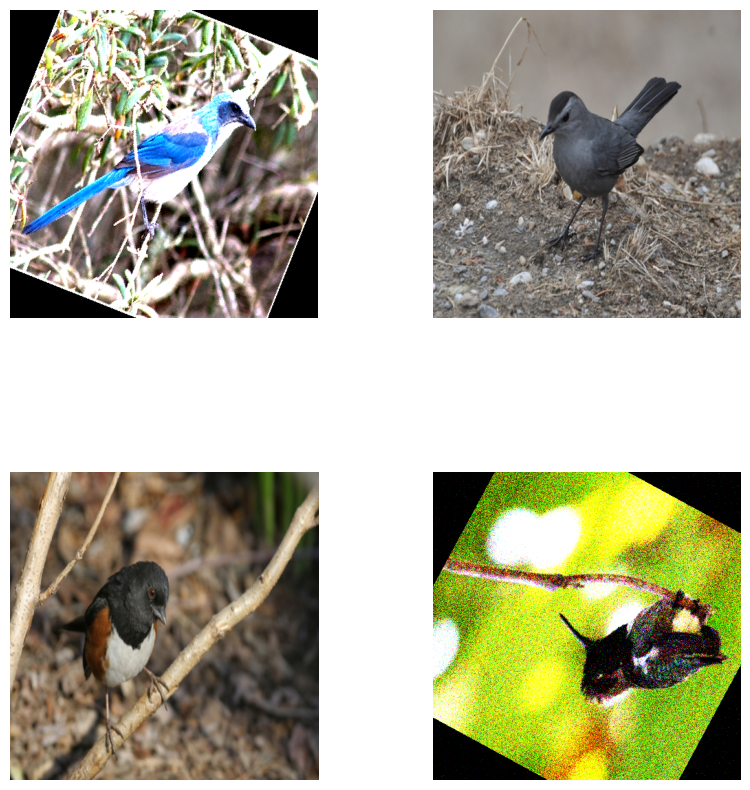

Batch 2


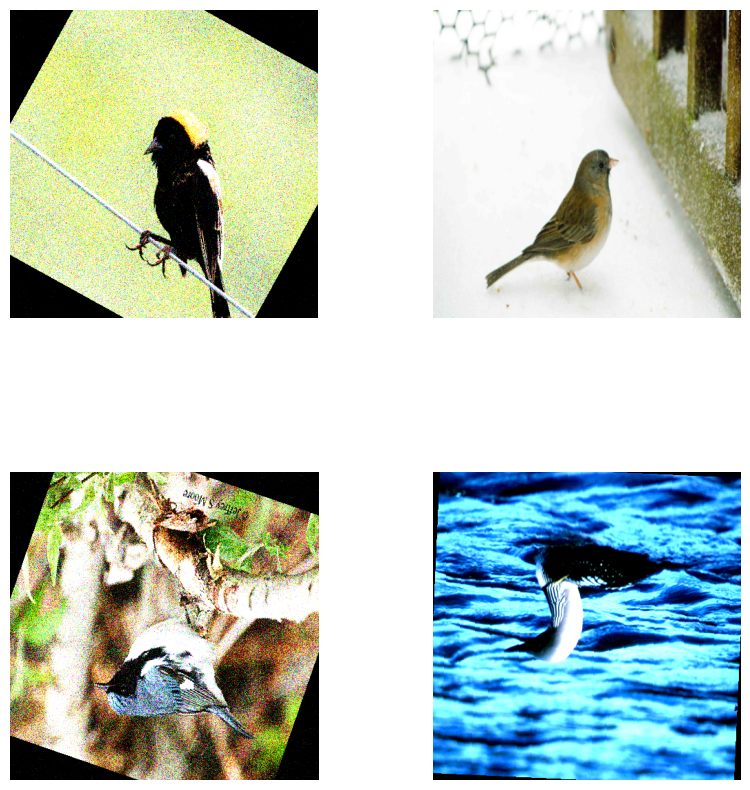

In [12]:
import matplotlib.pyplot as plt

num_rows = 2  # You can change this to the desired number of rows
num_cols = 2  # You can change this to the desired number of columns

# Function to unnormalize and display a grid of images
def imshow_grid(images, num_rows, num_cols):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.5)  # Adjust vertical spacing between subplots
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < len(images):
                img = images[index]
                npimg = img.numpy()
                ax = axes[i, j]
                ax.imshow(np.transpose(npimg, (1, 2, 0)))
                ax.axis('off')

    plt.show()

# Iterate through the train_loader
for batch_idx, (images, labels) in enumerate(train_loader):
    if batch_idx >= 2:
        break  # Stop after visualizing the specified number of batches

    print(f"Batch {batch_idx + 1}")
    imshow_grid(images, num_rows, num_cols)  # Display the grid of images

In [13]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 25.8 MB/s eta 0:00:00


In [14]:
from transformers import get_cosine_schedule_with_warmup

### Model / Optimizer ###
EPOCH = 30
lr = 0.0001

model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=50)
print(model)

### Tranfer Learning ###
model.to(DEVICE)

optimizer = AdamP(model.parameters(), lr=lr)

scheduler = get_cosine_schedule_with_warmup(optimizer,
                                    num_warmup_steps=len(train_loader)*3,
                                    num_training_steps=len(train_loader)*EPOCH)

print("Created a learning model and optimizer")

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 166MB/s]


Loaded pretrained weights for efficientnet-b0
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kern

In [15]:
### Train/Evaluation ###
def train(model,train_loader,optimizer,epoch, scheduler):
  model.train()
  criterion = nn.CrossEntropyLoss(label_smoothing=0.11)
  for i,(image,target) in enumerate(train_loader):
    image,target = image.to(DEVICE),target.to(DEVICE)
    output = model(image)
    optimizer.zero_grad()
    train_loss = criterion(output,target)

    train_loss.backward()
    optimizer.step()

    if scheduler != None:
      scheduler.step()

    if i%10 ==0:
      print(
          f'Train Epoch: {epoch} [{i}/{len(train_loader)}]\tloss: {train_loss.item():6f}')

  return train_loss

def evaluate(model,val_loader):
  model.eval()
  eval_loss = 0
  correct = 0
  with torch.no_grad():
    for i,(image,target) in enumerate(val_loader):
      image,target = image.to(DEVICE),target.to(DEVICE)
      output = model(image)

      eval_loss += F.cross_entropy(output,target, reduction='sum').item()
      pred = output.max(1,keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()

  eval_loss /= len(val_loader.dataset)
  eval_accuracy = 100*correct / len(val_loader.dataset)
  return eval_loss,eval_accuracy

In [16]:
wandb.define_metric("train_loss", summary = "min")
wandb.define_metric("val_loss", summary = "min")
wandb.define_metric("val_acc", summary = "max")

In [17]:
### Main ###
start = time.time()
best = 0
train_losses = []  # 훈련 손실을 저장할 목록
val_losses = []    # 검증 손실을 저장할 목록
val_accuracys = []

for epoch in range(EPOCH):
  train_loss = train(model,train_loader,optimizer,epoch, scheduler)
  val_loss,val_accuracy = evaluate(model,val_loader)
  # Log train loss, validation loss, and validation accuracy into Weight & Biases by the function of epoch
  wandb.log({"train_loss": train_loss, "val_loss": val_loss, "val_acc": val_accuracy}, step=epoch)

# 훈련 및 검증 손실을 목록에 추가
  train_losses.append(train_loss)
  val_losses.append(val_loss)

  # Save best model
  if val_accuracy > best:
    best = val_accuracy
    torch.save(model.state_dict(),"./best_model.pth")

  val_accuracys.append(val_accuracy)
  print(f"[{epoch}]Validation Loss: {val_loss:.4f},Accuracy: {val_accuracy:.4f}%")

# Test result
test_loss,test_accuracy = evaluate(model,test_loader)
print(f'[FINAL] Test Loss: {test_loss:.4f},Accuracy: {test_accuracy:.4f}%')

end = time.time()
elasped_time = end - start

print("Best Accuracy: ",best)
print(
    f"Elasped Time: {int(elasped_time/3600)}h, {int(elasped_time/60)}m, {int(elasped_time%60)}s")
print(
    f"time: {int(elasped_time/3600)}h, {int(elasped_time/60)}m, {int(elasped_time%60)}s")

Train Epoch: 0 [0/590]	loss: 3.926377
Train Epoch: 0 [10/590]	loss: 3.907847
Train Epoch: 0 [20/590]	loss: 3.971967
Train Epoch: 0 [30/590]	loss: 3.930654
Train Epoch: 0 [40/590]	loss: 3.928149
Train Epoch: 0 [50/590]	loss: 3.855600
Train Epoch: 0 [60/590]	loss: 3.944541
Train Epoch: 0 [70/590]	loss: 3.918678
Train Epoch: 0 [80/590]	loss: 3.908726
Train Epoch: 0 [90/590]	loss: 3.945847
Train Epoch: 0 [100/590]	loss: 3.909600
Train Epoch: 0 [110/590]	loss: 3.921430
Train Epoch: 0 [120/590]	loss: 3.865200
Train Epoch: 0 [130/590]	loss: 3.930274
Train Epoch: 0 [140/590]	loss: 3.870338
Train Epoch: 0 [150/590]	loss: 3.842726
Train Epoch: 0 [160/590]	loss: 3.880876
Train Epoch: 0 [170/590]	loss: 3.911875
Train Epoch: 0 [180/590]	loss: 3.892739
Train Epoch: 0 [190/590]	loss: 4.006798
Train Epoch: 0 [200/590]	loss: 3.879202
Train Epoch: 0 [210/590]	loss: 3.838874
Train Epoch: 0 [220/590]	loss: 3.957689
Train Epoch: 0 [230/590]	loss: 3.882905
Train Epoch: 0 [240/590]	loss: 3.935701
Train Epoch

In [18]:
# Finish Weight & Biases
wandb.finish()

train_loss,█▆▃▃▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▇▇▇█████████████████████████
val_loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


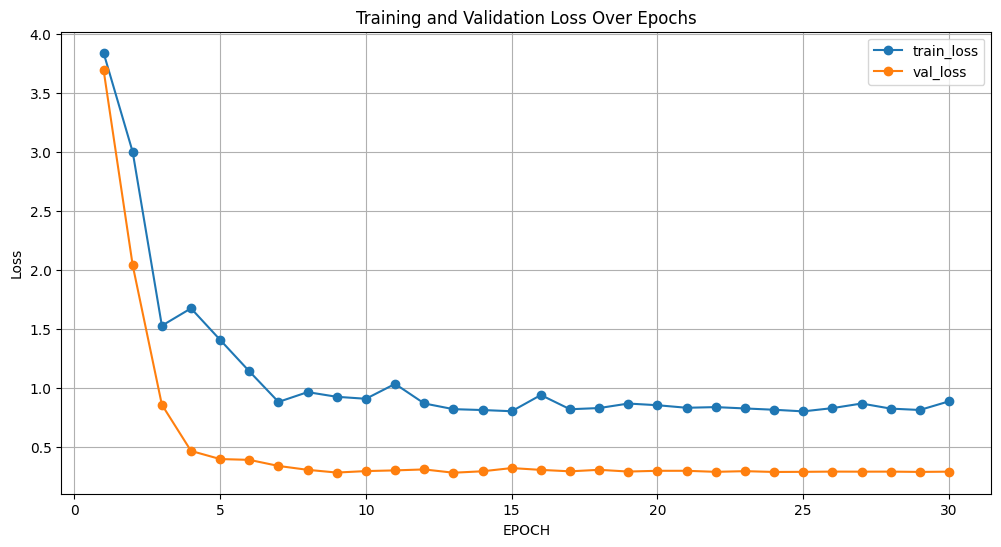

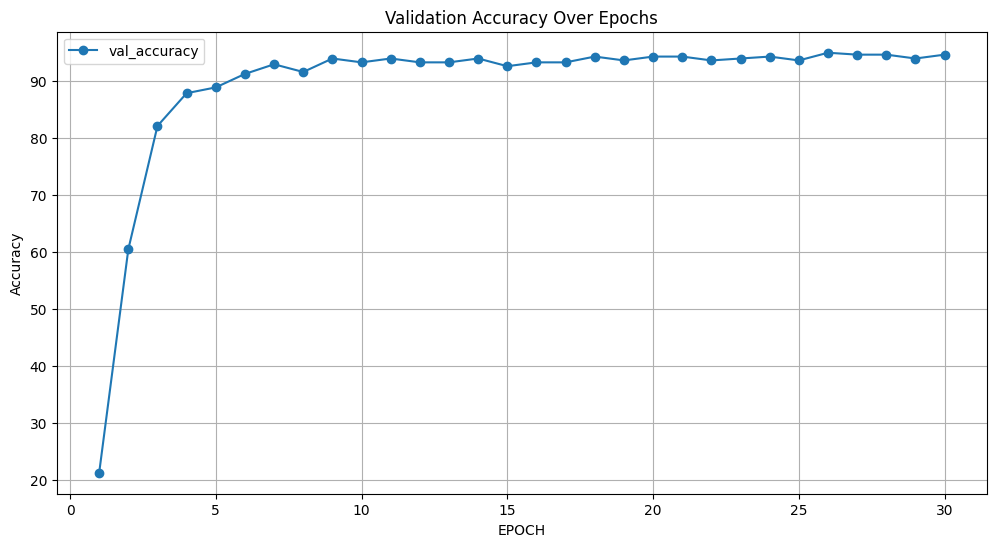

In [19]:
# 이제 손실 값을 플로팅합니다.
import matplotlib.pyplot as plt

# train_loss와 val_loss 텐서를 CPU로 이동하고 NumPy 배열로 변환
train_losses = [loss.cpu().detach().numpy() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
val_losses = [loss.cpu().detach().numpy() if isinstance(loss, torch.Tensor) else loss for loss in val_losses]

plt.figure(figsize=(12, 6))
plt.plot(range(1, EPOCH + 1), train_losses, label='train_loss', marker='o')
plt.plot(range(1, EPOCH + 1), val_losses, label='val_loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')

plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


val_accuracys = [acc.cpu().detach().numpy() if isinstance(acc, torch.Tensor) else acc for acc in val_accuracys]
plt.figure(figsize=(12, 6))
plt.plot(range(1, EPOCH + 1), val_accuracys, label='val_accuracy', marker='o')
plt.title('Validation Accuracy Over Epochs')

plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

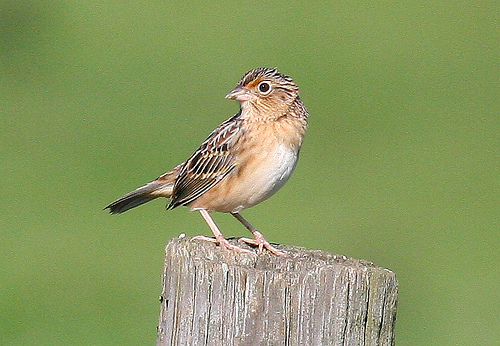

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image
import random

# 테스트 데이터셋에서 무작위로 이미지 선택
random_index = random.randint(0, len(test_set) - 1)
img_path = test_set.image_folder[random_index]
img_path = os.path.join('/content/gdrive/MyDrive/Colab Notebooks/CUB_200_2011_repackage_class50/datasets/test',img_path)
display(Image(img_path))

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

35363/35363 [==============================] - 0s 0us/step
Predicted: [('n01534433', 'junco', 7.46398)]


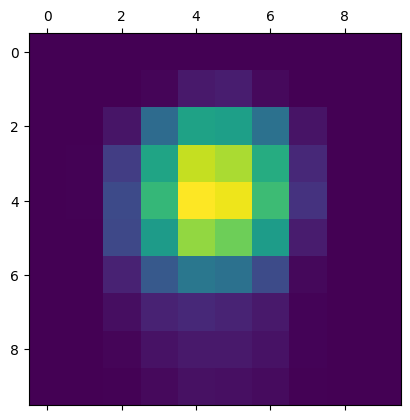

In [21]:

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

<ipython-input-22-8a3df7f2985d>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


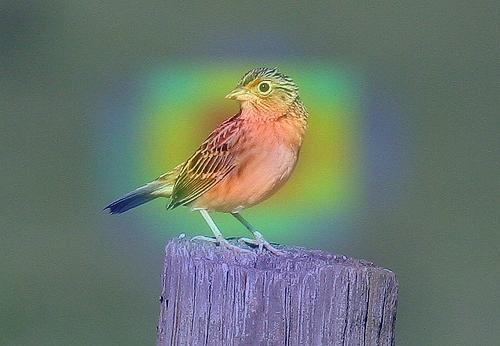

In [22]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)